In [1]:
import copy
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# paths
G6_GRAPH_PATH = '../datasets/graph6/n10_blocks_toy/'
#G6_GRAPH_NUM_FILES = len([name for name in os.listdir(G6_GRAPH_PATH) if os.path.isfile(os.path.join(G6_GRAPH_PATH, name))])
G6_GRAPH_NUM_FILES = 10
RESULT_DATA_PATH = 'opt_results/n10_blocks_toy/'
#BUFFER = 300
#NUM_NODES = 10

In [3]:
# functions
def load_data():
    dataset = np.load('../datasets/opt_band_10_nodes_graph.npy')
    np.random.shuffle(dataset)
    len_train = int(dataset.shape[0]*0.6)
    len_val = int(dataset.shape[0]*0.2)
    len_test = dataset.shape[0]-len_train-len_val
    #X_train, Y_train = dataset[:len_train,:100], dataset[:len_train,100:]
    data_train = dataset[:len_train]
    X_val, Y_val = dataset[len_train:len_train+len_val,:100], dataset[len_train:len_train+len_val,100:]
    X_test, Y_test = dataset[len_train+len_val:,:100], dataset[len_train+len_val:,100:]
    #return X_train,Y_train,X_val,Y_val,X_test,Y_test
    return data_train,X_val,Y_val,X_test,Y_test

In [4]:
#X_train, Y_train, X_val, Y_val, X_test, Y_test = load_data()
data_train, X_val, Y_val, X_test, Y_test = load_data()
print(data_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(7206, 110)
(2402, 100) (2402, 10)
(2402, 100) (2402, 10)


In [5]:
data_train = torch.tensor(data_train,dtype=torch.float)
X_val = torch.tensor(X_val,dtype=torch.float)
Y_val = torch.tensor(Y_val,dtype=torch.float)
X_test = torch.tensor(X_test,dtype=torch.float)
Y_test = torch.tensor(Y_test,dtype=torch.float)

In [6]:
# hiperparams
opt_params = [(0.9,0.0), (0.4,0.0), (0.1,0.0), (0.9,0.4), (0.1,0.4)] # (learning_rate, momentum)

# train params
#epochs = 10000
epochs = 1000
goal = 0.5e-3
#show = 100
show = 20

In [7]:
# neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(45, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self,output,target):
        #return ((output-target)**2).mean() + (output % 1).sum(dim=1).mean()
        return ((output-target)**2).mean()
        #return ((output-target)**2).sum(dim=1).mean()
    
criterion = CustomLoss()

In [9]:
# train

# net instance
net = Net()
# optimizer
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=mm)
optimizer = optim.SGD(net.parameters(), lr=0.001)

train_loss = list()
valid_loss = list()
train_size = data_train.size()[0]
batch_size = 30
batchs = train_size // batch_size
        
print('\nTrainning')
for epoch in range(epochs): # loop over the dataset multiple times
    
    data_train = data_train[torch.randperm(train_size)] # shuffle
    X_train, Y_train = data_train[:,:100], data_train[:,100:] # split
    
    start = 0
    end = batch_size
    
    for _ in range(batchs):
        batch = X_train[start:end]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(batch)
        loss = criterion(outputs, Y_train[start:end])
        loss.backward()
        optimizer.step()
        
        start += batch_size
        end += batch_size

        # goal
        if loss.item() <= goal:
            print('The goal of learning is reached')
            print('{} Loss: {}'.format(epoch+1, loss.item()))
            break
            
    # store error
    train_loss.append(loss.item())
    out = net(X_val)
    val_loss = criterion(out,Y_val)
    valid_loss.append(val_loss.item())
            
    # print statistics
    if epoch % show == show-1: # print every show epochs
        print('{} Loss: {}'.format(epoch+1, loss.item()))
            
    if loss.item() <= goal:
        break
        
print('Finished Training')


Trainning
20 Loss: 5.988676071166992
40 Loss: 5.497799396514893
60 Loss: 5.418017387390137
80 Loss: 5.853803634643555
100 Loss: 6.3499436378479
120 Loss: 7.0006256103515625
140 Loss: 4.719515323638916
160 Loss: 6.185303211212158
180 Loss: 5.181384086608887
200 Loss: 5.430373668670654
220 Loss: 6.27240514755249
240 Loss: 5.916441917419434
260 Loss: 5.932056903839111
280 Loss: 5.233405590057373
300 Loss: 5.532390594482422
320 Loss: 5.809094429016113
340 Loss: 4.27669620513916
360 Loss: 6.180533409118652
380 Loss: 5.529397964477539
400 Loss: 4.613333702087402
420 Loss: 4.803040981292725
440 Loss: 5.458315372467041
460 Loss: 6.171590328216553
480 Loss: 5.040018081665039
500 Loss: 5.563745021820068
520 Loss: 5.705639839172363
540 Loss: 5.359729290008545
560 Loss: 5.581821441650391
580 Loss: 5.571043014526367
600 Loss: 4.139194965362549
620 Loss: 6.563718318939209
640 Loss: 3.969479560852051
660 Loss: 5.426319122314453
680 Loss: 5.760090351104736
700 Loss: 5.57887077331543
720 Loss: 6.20964

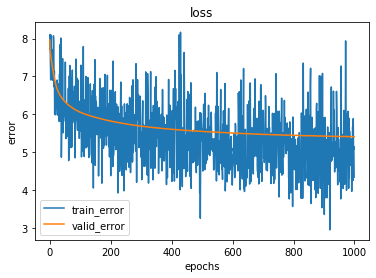

In [10]:
x = list(range(len(train_loss)))

# consolidate
fig, ax = plt.subplots()
ax.plot(x, train_loss, label='train_error')
ax.plot(x, valid_loss, label='valid_error')
ax.set(xlabel='epochs', ylabel='error', title='loss')

plt.legend()
#plt.savefig('loss.png')
plt.show()

In [13]:
out = net(X_val)
error = criterion(out,Y_val)
error

tensor(5.4135, grad_fn=<MeanBackward0>)

In [18]:
out = net(X_val[0])
print(out.round())
print(Y_val[0])

tensor([7., 5., 2., 3., 5., 4., 5., 6., 3., 4.], grad_fn=<RoundBackward>)
tensor([9., 5., 1., 2., 7., 0., 6., 8., 4., 3.])


# A partir daqui são apenas tentativas que não deram certo.
# Abaixo o senhor verá classes e funções que tentei implementar

In [11]:
(outputs % 1).sum(dim=1).mean()

tensor(4.8743, grad_fn=<MeanBackward0>)

In [25]:
x = torch.randn(3,2)
x_perm = x[torch.randperm(3)]
x

tensor([[-0.8532, -2.3568],
        [ 0.1840, -0.7984],
        [ 0.1156,  0.3890]])

In [6]:
# criterion
class BandwidthLoss(torch.nn.Module):
    
    def __init__(self):
        super(BandwidthLoss,self).__init__()
        
    def forward(self,X,OUT,Y):
        diff = torch.sum((OUT - Y)**2,1)
        return torch.mean(diff)

criterion = BandwidthLoss()

In [14]:
# criterion
class BandwidthLoss(torch.nn.Module):
    
    def __init__(self):
        super(BandwidthLoss,self).__init__()
        
    def forward(self,X,OUT,Y):
        
        worst_band = torch.tensor(9) # edge between node 1 and node 10
    
        # p1, distance between bands
        # p2, repeated nums in sequence
        # p3, sum of decimals
        p1 = p2 = p3 = torch.tensor(0)

        for x,out,y in list(zip(X,OUT,Y)):

            ### p1
            #print(out)
            p = set()
            out_list = list(map(round,out.clone().tolist()))
            for item in out_list:
                #print(item, end=' ')
                p.add(item)
            #print(p)
            if len(p) < 10:
                p1 = torch.add(p1,worst_band)
            else:
                graph = nx.from_numpy_array(x.numpy().reshape(10,10))
                print('achou seq valido: ', out.clone().tolist())
                out_band = get_bandwidth(graph,out_list)
                y_band = get_bandwidth(graph,list(map(round,y.clone().tolist())))
                print(out_band,y_band,out_band-y_band)
                break

            ### p2
            #p2 += 10 - len(p)
            p2 = torch.add(p2,10-len(p))

            ### p3

        # J = (p1+p2) * (p3+1)
        J = torch.tensor((torch.mul((p1/len(OUT)), (p2+1))), dtype=torch.float) 
        J.requires_grad = True
        #J.grad_fn = BandwidthLoss()
        return J
        
        
        #y_shape = y.size()[1]
        #x_added_dim = x.unsqueeze(1)
        #x_stacked_along_dimension1 = x_added_dim.repeat(1,NUM_WORDS,1)
        #diff = torch.sum((y - x_stacked_along_dimension1)**2,2)
        #totloss = torch.sum(torch.sum(torch.sum(diff)))
        #return totloss




def bandwidth_loss(X,OUT,Y):
    
    worst_band = 9 # edge between node 1 and node 10
    
    # p1, distance between bands
    # p2, repeated nums in sequence
    # p3, sum of decimals
    p1 = p2 = p3 = 0
    
    for x,out,y in list(zip(X,OUT,Y)):
        
        ### p1
        #print(out)
        p = set()
        out_list = list(map(round,out.clone().tolist()))
        for item in out_list:
            #print(item, end=' ')
            p.add(item)
        #print(p)
        if len(p) < 10:
            p1 += worst_band
        else:
            graph = nx.from_numpy_array(x.numpy().reshape(10,10))
            print('achou seq valido: ', out.clone().tolist())
            out_band = get_bandwidth(graph,out_list)
            y_band = get_bandwidth(graph,list(map(round,y.clone().tolist())))
            print(out_band,y_band,out_band-y_band)
            break
    
        ### p2
        #p2 += 10 - len(p)
        
        ### p3
    
    # J = (p1+p2) * (p3+1)
    #return torch.mul((p1/len(OUT)), (p2+1))
    return p1


def criterion_teste(y_pred, y):
    return (y_pred - y).pow(2).sum()

#criterion = nn.MSELoss()
#criterion = bandwidth_loss
criterion = criterion_teste
#criterion = BandwidthLoss()

In [12]:
def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss

model = nn.Linear(2, 2)
x = torch.randn(1, 2)
target = torch.randn(1, 2)
output = model(x)
loss = my_loss(output, target)
loss.backward()
print(model.weight.grad)

tensor([[-0.4783,  0.2935],
        [ 0.7380, -0.4529]])


In [37]:
w = torch.randint(9,(3,3))
z = torch.randint(9,(3,3))
print(w)
print(z)
print((w - z)**2)
diff = torch.sum((w - z)**2,1)
print(diff)
torch.mean(diff)

tensor([[2, 3, 6],
        [3, 3, 8],
        [8, 4, 1]])
tensor([[1, 2, 5],
        [3, 7, 0],
        [6, 4, 4]])
tensor([[ 1,  1,  1],
        [ 0, 16, 64],
        [ 4,  0,  9]])
tensor([ 3, 80, 13])


RuntimeError: Can only calculate the mean of floating types. Got Long instead.

In [ ]:
def calcula_banda(sequence):
    # calculos
    return banda # int


def criterion(OUT,TARGET):
    J = 0
    for out,target in list(zip(OUT,TARGET)):
        banda_out = calcula_banda(out)
        banda_target = calcula_banda(target)
        distancia = banda_out - banda_target
        J += distancia
    return J